In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Building Machines

Beginning to build non-linear statistical prediction machines. Simple in nature, complicated in interactions.

## UC Berkely Admissions 

4526 graduate school applications for 1973 UC Berkely

Stratified by department and gender of applicant

Gender discrimination by admission officers?

**Mediation Analysis**

Causal foundations of bias, disparity and fairness - V.A.Traag, L. Waltman 2022

Rare outline of explicit causal framework, some dags, actual estimand

## Modelling events

Events: Discrete, unordered outcomes

Observations are counts

Unknowns are probabilities, odds

Everything interacts always everywhere

A beast known as "log-odds"

Will be mainly modelling on the logarithmmic scale

## Admissions

Was there gender discrimination in graduate admissions?
(gender) G->A (admission)

department(D) -> G
D             -> A

Some departments receive lot of applicants, some much less. 

What can the "causal effect of gender" mean?

Not the applicants gender that matters, but their perceived gender by the referee (who influences acceptance)

## Context & discrimination

x -> y ("direct discrimination)
x -> z -> y ("indirect discrimination, structural")

total discrimination is the sum of both types (its what people experience!)

each type requires a different estimator 


Which path is "discrimination"? 

Often the thing we want is not what we're able to estimate. 

Will deal with unobserved confounds later 

In [2]:
# Generative model, basic mediator scenario
#No Discrimination

N = 1000 # Number of applicants
# Even Gender distribution 
G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
accept_rate = np.array([[0.1,0.1],[0.3,0.3]])
# Simulate acceptance
A = np.random.binomial(1,accept_rate[D,G])

GD = np.histogram2d(G, D, bins=(2,2))[0]
GA = np.histogram2d(G, A, bins=(2,2))[0]

print('GD')
print(GD)
print('GA')
print(GA)
print('Acceptance Rates')
print('Gender 0: '+ str(GA[0,1]/np.sum(GA[0])))
print('Gender 1: '+ str(GA[1,1]/np.sum(GA[1])))

GD
[[367. 128.]
 [ 97. 408.]]
GA
[[423.  72.]
 [366. 139.]]
Acceptance Rates
Gender 0: 0.14545454545454545
Gender 1: 0.27524752475247527


In [3]:
# Generative model, basic mediator scenario
#Some Direct discrimination

N = 1000 # Number of applicants
# Even Gender distribution 
G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
A = np.random.binomial(1,accept_rate[D,G])

GD = np.histogram2d(G, D, bins=(2,2))[0]
GA = np.histogram2d(G, A, bins=(2,2))[0]

print('GD')
print(GD)
print('GA')
print(GA)
print('Acceptance Rates')
print('Gender 0: '+ str(GA[0,1]/np.sum(GA[0])))
print('Gender 1: '+ str(GA[1,1]/np.sum(GA[1])))

#Overall pattern is the same as the absence of discrimination!!!!

GD
[[334. 163.]
 [ 95. 408.]]
GA
[[446.  51.]
 [375. 128.]]
Acceptance Rates
Gender 0: 0.10261569416498995
Gender 1: 0.2544731610337972


## Generative model

Could do a lot better

Admission rate depends upon size of applicant pool, distribution of qualifications

Should sample applicant pool and then sort to select admissions

Rates are conditional on structure of applicant pool

## Modeling events

**We Observe**: Counts of events

**We estimate**: Probability (or log-odds) of events

Like the globe tossing model. but need "proportion of water" stratified by other variables.




## Generalized Linear Models

**Linear Models**: Expected value is additive ("linear")combination of parameters

e.g.Y ~ Normal (mu,sigma) 
mu = a + BxX + BzZ

You can't do this with any distribution except the normal. The normal is unbounded

Other variables are bounded. Such as events which are counts.

**Generalized Linear Models**: Expected value is some function of an additive combination of parameters.

e.g. Y ~ Bernoulli(p) For each i, Y is a 0/1 outcome
f(p) = a + Bx + BzZ

f is the link function

Links parameters of distribution to linear model
f ^-1 is the inverse link function

E.g.
f(a) = a^2
f^-1(a^2) = sqrt(a^2) = a 


## Distributions and link functions

Distributions: Relative number of ways to observe data given assumptiosn about rates probabilities, slops, etc.

Distributions are matched to contraints on observed variables

Link functions are matched to distributions

## Exponential Family

Distribution of the time to an event that has a constant rate in time. Positive real values. Has 1 paramter Lambda which is the rate 

If you have some process that is producing events in continuous time and you count them, you get a Binomial distribution.

**Poisson** is a special case of binomial where you don't know the maximum. Has the same lambda 

**Gamma** sum of exponential processes (lambda, k)

**Normal** For large means you become absorbed by the Normal! (mean, variance)

Think about the mapping. 

Distributional assumptions are assumptions about constraints on observations

You cannot "test" if you data are "normal"

## Distributions and link functions

Distributions: Relative number of ways to observe data given assumptions

Distributions are matched to contstraints on observed variables

Link functions are matched to distributions

## Logit Link

Bernoulli/Binomial models most often use *logit** link

logit(pi) = log(p/(1-p)

Yi ~ Bernoulli(p)

logit(p) = a +BxX + BzZ

## Logit link is hars transform

"log-odds scale": The value of the linear model 

logit(p)=0,p=0.5

logit(p)=4,p=nearly always

logit(p)=-4,p=hardly ever


## Logistic priors

logit(pi) = a

The logit link compresses parameter distributions

Anything above +4 = almost always

Anything below -4 = almost never 

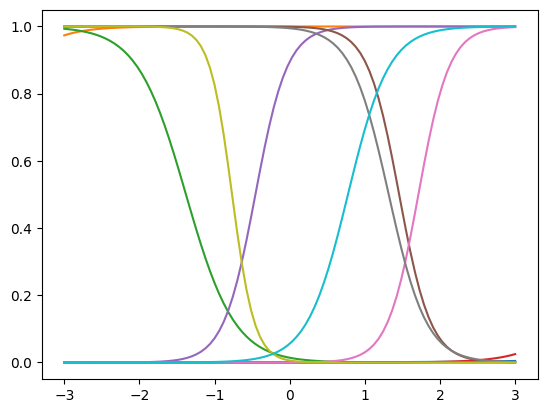

In [4]:
a = np.random.normal(0,10, size=1000)
b = np.random.normal(0,10, size=1000)
xseq = np.linspace(-3,3,num=100)
plist = []

for x in xseq:
    p = expit(a+b*x)
    plist.append(p[:10])
plist = np.array(plist)

for i in range(10): 
    plt.plot(xseq,plist[:,i])

#Assumes very strong associations between x and probability apriori

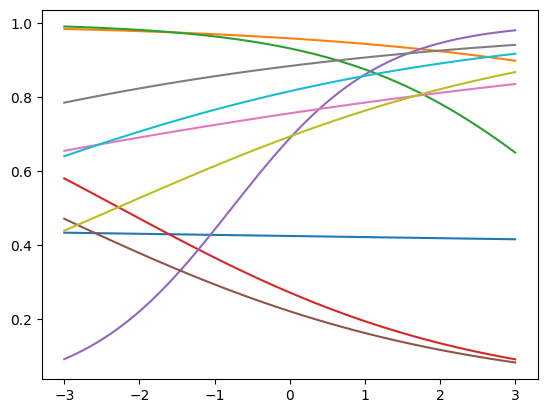

In [5]:
a = np.random.normal(0,1.5, size=1000)
b = np.random.normal(0,.5, size=1000)
xseq = np.linspace(-3,3,num=100)
plist = []

for x in xseq:
    p = expit(a+b*x)
    plist.append(p[:10])
plist = np.array(plist)

for i in range(10): 
    plt.plot(xseq,plist[:,i])
#Much more regularized, defensible 

In [9]:
with pm.Model() as total_sim:
    N = 1000 # Number of applicants
# Even Gender distribution 
    G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
    D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
    accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
    A = np.random.binomial(1,accept_rate[D,G])
    
    a = pm.Normal('a',0,1,shape=2)
    p =  pm.Deterministic("p", pm.math.invlogit(a[G]))
    A = pm.Bernoulli('A', p, observed = A)
    
    tsim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [6]:
with pm.Model() as direct_sim:
    N = 1000 # Number of applicants
# Even Gender distribution 
    G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
    D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
    accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
    A = np.random.binomial(1,accept_rate[D,G])
    
    #The model
    a = pm.Normal('a',0,1,shape=(2,2))
    p =  pm.Deterministic("p", pm.invlogit(a[G, D]))
    #A = pm.Bernoulli('A', p, observed = A)
    likelihood = pm.Bernoulli('A', p=p, observed=A)
    dsim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [11]:
az.summary(tsim_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-2.329,0.155,-2.648,-2.061,0.002,0.002,4302.0,2993.0,1.0
a[1],-0.970,0.104,-1.166,-0.778,0.002,0.001,3994.0,2781.0,1.0


In [16]:
#Turning into the probability scale
expit(az.summary(dsim_trace)[:4]['mean'])

a[0, 0]    0.070371
a[0, 1]    0.224784
a[1, 0]    0.110171
a[1, 1]    0.309598
Name: mean, dtype: float64

In [18]:
##Actual Data

admin = pd.read_csv('./Data/UCBadmit.csv',sep=';')
admin.head()
#Note counts, turns it into a binomial 

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [19]:
admin['dept'].nunique()

6

In [24]:
admin['dept'].astype('category').cat.codes

1     0
2     0
3     1
4     1
5     2
6     2
7     3
8     3
9     4
10    4
11    5
12    5
dtype: int8

In [28]:
with pm.Model() as direct_model:
    G = admin['applicant.gender'].astype('category').cat.codes
    D = admin['dept'].astype('category').cat.codes
    N = admin['applications']
    a = pm.Normal('a',0,1,shape=(2,6)) #Shape is (genders,depts)
    p =  pm.Deterministic("p", pm.invlogit(a[G, D]))
    likelihood = pm.Binomial('A', N , p , observed=admin['admit'])
    direct_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [29]:
with pm.Model() as total_model:
    G = admin['applicant.gender'].astype('category').cat.codes
    D = admin['dept'].astype('category').cat.codes
    N = admin['applications']
    a = pm.Normal('a',0,1,shape=G.nunique()) #Shape is (genders,depts)
    p =  pm.Deterministic("p", pm.invlogit(a[G]))
    likelihood = pm.Binomial('A', N , p , observed=admin['admit'])
    total_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([[<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'p'}>,
        <AxesSubplot: title={'center': 'p'}>]], dtype=object)

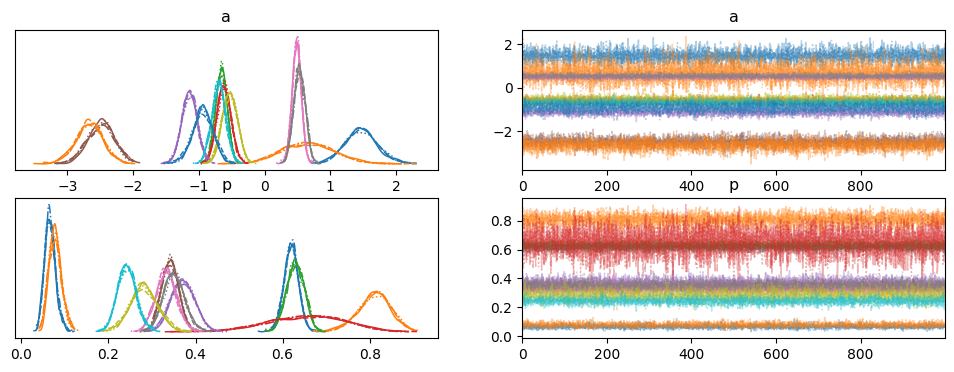

In [30]:
az.plot_trace(direct_trace)

In [32]:
az.summary(direct_trace)[:12]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",1.470,0.245,0.996,1.929,0.003,0.002,6200.0,3323.0,1.0
"a[0, 1]",0.660,0.397,-0.076,1.391,0.005,0.004,5838.0,3106.0,1.0
"a[0, 2]",-0.658,0.088,-0.824,-0.498,0.001,0.001,6340.0,3268.0,1.0
"a[0, 3]",-0.619,0.107,-0.830,-0.426,0.001,0.001,5785.0,2919.0,1.0
"a[0, 4]",-1.143,0.117,-1.359,-0.918,0.002,0.001,5728.0,3122.0,1.0
"a[0, 5]",-2.491,0.203,-2.880,-2.119,0.003,0.002,5149.0,2801.0,1.0
"a[1, 0]",0.489,0.071,0.362,0.627,0.001,0.001,5457.0,2997.0,1.0
"a[1, 1]",0.531,0.087,0.369,0.689,0.001,0.001,5376.0,3037.0,1.0
"a[1, 2]",-0.530,0.117,-0.749,-0.315,0.001,0.001,6218.0,3137.0,1.0
"a[1, 3]",-0.698,0.104,-0.899,-0.509,0.001,0.001,6022.0,2978.0,1.0


In [33]:
az.summary(total_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.830,0.050,-0.923,-0.738,0.001,0.001,4494.0,3162.0,1.0
a[1],-0.221,0.039,-0.290,-0.144,0.001,0.000,4286.0,3192.0,1.0


<AxesSubplot: >

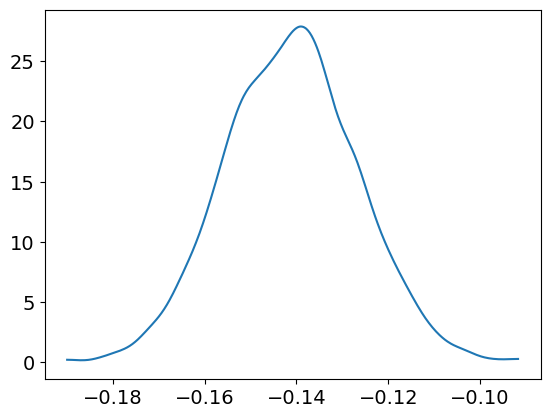

In [50]:
diff_prob = expit(total_trace.posterior.a[:,:,0].values) - expit(total_trace.posterior.a[:,:,1].values)
az.plot_kde(diff_prob)

#Men advantaged 

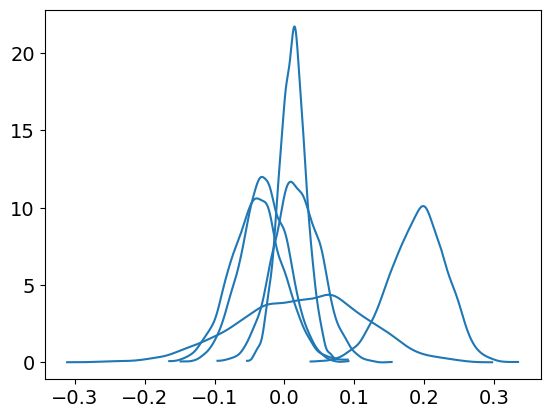

In [59]:
dexpit_a = expit(direct_trace.posterior.a)
diff_dept = dexpit_a[:,:,0,:].values - dexpit_a[:,:,1,:].values

for i in range(6):
    az.plot_kde(diff_dept[:,:,i])
#will figure out color later. 